Named Entity Recognition using Bi-LSTM

In [1]:
from nltk import word_tokenize, pos_tag, ne_chunk

sentence = 'James is working at Disney in London'
sentence = pos_tag(word_tokenize(sentence))
print(sentence)

[('James', 'NNP'), ('is', 'VBZ'), ('working', 'VBG'), ('at', 'IN'), ('Disney', 'NNP'), ('in', 'IN'), ('London', 'NNP')]


In [2]:
sentence = ne_chunk(sentence)
print(sentence)

(S
  (PERSON James/NNP)
  is/VBZ
  working/VBG
  at/IN
  (ORGANIZATION Disney/NNP)
  in/IN
  (GPE London/NNP))


BIO

* B - begin ; I - Inside ; O - Outside: 
ex) Harry Poter: 
    * BIIII IIIII OOOOOO
    * Harry Poter speaks

In [3]:
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

C:\Users\caffr\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
import os
os.listdir('data/')

['CONLL2003.txt',
 'glove.6B.zip',
 'glove.840B.300d.txt',
 'GoogleNews-vectors-negative300.bin.gz',
 'test.zip',
 'train.zip',
 'wonderland.txt']

In [6]:
f = open('data/CONLL2003.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') 
    splits[-1] = re.sub(r'\n', '', splits[-1]) 
    word = splits[0].lower() 
    sentence.append([word, splits[-1]]) 

In [7]:
print("Total Samples: ", len(tagged_sentences)) 

Total Samples:  14041


In [8]:
print(tagged_sentences[0])

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [9]:
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: 
    sentence, tag_info = zip(*tagged_sentence) 
    sentences.append(list(sentence)) 
    ner_tags.append(list(tag_info)) 

In [10]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


Max samp length : 113
Avg samp length : 14.501887


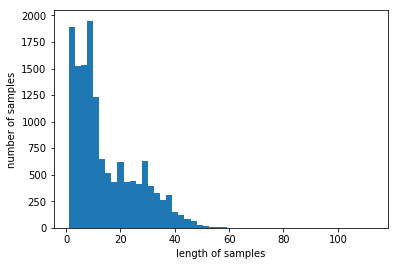

In [11]:
print('Max samp length : %d' % max(len(l) for l in sentences))
print('Avg samp length : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [12]:
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [13]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('vocab_size : {}'.format(vocab_size))
print('tag size : {}'.format(tag_size))

vocab_size : 4000
tag size : 10


In [14]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [15]:
print(X_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [16]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [17]:
decoded = []
for index in X_train[0] : 
    decoded.append(index_to_word[index]) 

print('Original Sentence : {}'.format(sentences[0]))
print('OOV words : {}'.format(decoded))

Original Sentence : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
OOV words : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [18]:
max_len = 70
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)

y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [20]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [21]:
print('training sample size : {}'.format(X_train.shape))
print('training label size : {}'.format(y_train.shape))
print('testing sample size : {}'.format(X_test.shape))
print('testing lable size : {}'.format(y_test.shape))

training sample size : (11232, 70)
training label size : (11232, 70, 10)
testing sample size : (2809, 70)
testing lable size : (2809, 70, 10)


In [22]:
## Bi-directional LSTM
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 128, input_length = max_len, mask_zero = True), 
    Bidirectional(LSTM(256, return_sequences = True)), 
    TimeDistributed(Dense(tag_size, activation = 'softmax'))
])

model.compile(optimizer= Adam(0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
model.fit(X_train, y_train, batch_size=128, epochs= 8, validation_data=(X_test, y_test))

C:\Users\caffr\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:353: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11232 samples, validate on 2809 samples
Epoch 1/8
11232/11232 [==============================] - 89s 8ms/step - loss: 0.0908 - accuracy: 0.8820 - val_loss: 0.0372 - val_accuracy: 0.9478
Epoch 2/8
11232/11232 [==============================] - 99s 9ms/step - loss: 0.0310 - accuracy: 0.9563 - val_loss: 0.0310 - val_accuracy: 0.9565
Epoch 3/8
11232/11232 [==============================] - 99s 9ms/step - loss: 0.0224 - accuracy: 0.9673 - val_loss: 0.0284 - val_accuracy: 0.9614
Epoch 4/8
11232/11232 [==============================] - 101s 9ms/step - loss: 0.0178 - accuracy: 0.9735 - val_loss: 0.0296 - val_accuracy: 0.9597
Epoch 5/8
11232/11232 [==============================] - 102s 9ms/step - loss: 0.0138 - accuracy: 0.9793 - val_loss: 0.0311 - val_accuracy: 0.9630
Epoch 6/8
11232/11232 [==============================] - 104s 9ms/step - loss: 0.0101 - accuracy: 0.9848 - val_loss: 0.0345 - val_accuracy: 0.9617
Epoch 7/8
11232/11232 [==============================] - 102s 9ms/step -

In [24]:
print("\n test accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

2809/2809 [==============================] - 11s 4ms/step

 test accuracy: 0.9596


In [25]:
i=10 
y_predicted = model.predict(np.array([X_test[i]])) 
y_predicted = np.argmax(y_predicted, axis=-1) 
true = np.argmax(y_test[i], -1) 

print("{:15}|{:5}|{}".format("word", "actual", "prediction"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # removing PAD
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

word           |actual|prediction
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       I-MISC
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : 